# Feature Selection

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import bokeh
from bokeh.io import output_notebook
output_notebook()

import os

Loading BokehJS ...

In [2]:
DATA_STREETLIGHT_CASES_URL = 'https://data.sfgov.org/api/views/c53t-rr3f/rows.json?accessType=DOWNLOAD'
DATA_STREETLIGHT_CASES_LOCAL = 'DATA_STREETLIGHT_CASES.json'

data_path = DATA_STREETLIGHT_CASES_URL
if os.path.isfile(DATA_STREETLIGHT_CASES_LOCAL):
    data_path = DATA_STREETLIGHT_CASES_LOCAL

In [3]:
import urllib, json

def _load_data(url):
    response = urllib.urlopen(url)
    raw_data = json.loads(response.read())
    columns = [col['name'] for col in raw_data['meta']['view']['columns']]
    rows = raw_data['data']
    return pd.DataFrame(data=rows, columns=columns)

In [4]:
df = _load_data(data_path)

In [5]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [6]:
df['opened'] = pd.to_datetime(df.opened)
df['opened_dayofweek'] = df.opened.dt.dayofweek
df['opened_month'] = df.opened.dt.month
df['opened_year'] = df.opened.dt.year
df['opened_dayofmonth'] = df.opened.dt.day
df['opened_weekend'] = df.opened_dayofweek >= 5

df['closed'] = pd.to_datetime(df.closed)
df['closed_dayofweek'] = df.closed.dt.dayofweek
df['closed_month'] = df.closed.dt.month
df['closed_year'] = df.closed.dt.year
df['closed_dayofmonth'] = df.closed.dt.day
df['closed_weekend'] = df.closed_dayofweek >= 5

In [7]:
df['delta'] = (df.closed - df.opened).dt.days
df['is_open'] = pd.isnull(df.closed)
df['target'] = df.delta <= 2

In [8]:
from geopy.distance import vincenty

df['latitude'] = df.point.apply(lambda e: float(e[1]))
df['longitude'] = df.point.apply(lambda e: float(e[2]))

In [9]:
min_lat, max_lat = min(df.latitude), max(df.latitude)
min_lng, max_lng = min(df.longitude), max(df.longitude)

def grid(lat, lng):
    x = vincenty((lat, min_lng), (lat, lng)).miles
    y = vincenty((min_lat, lng), (lat, lng)).miles
    return x, y

xy = [grid(lat, lng) for lat, lng in zip(df.latitude.values, df.longitude.values)]

df['loc_x'] = np.array(xy)[:,0]
df['loc_y'] = np.array(xy)[:,1]

In [10]:
dummies = pd.get_dummies(df.neighborhood.str.replace(' ', '_').str.lower(), prefix='neigh_', drop_first=False)
df[dummies.columns] = dummies
del df['neighborhood']

In [11]:
dummies = pd.get_dummies(df.category.str.replace(' ', '_').str.lower(), prefix='cat_', drop_first=False)
df[dummies.columns] = dummies
del df['category']

In [12]:
dummies = pd.get_dummies(df.source.str.replace(' ', '_').str.lower(), prefix='source_', drop_first=False)
df[dummies.columns] = dummies
del df['source']

In [13]:
df['status'] = df.status == 'Closed'

In [14]:
del df['sid']
del df['id']
del df['position']
del df['created_at']
del df['created_meta']
del df['updated_at']
del df['updated_meta']
del df['meta']
del df['caseid']
del df['address']
del df['responsible_agency']
del df['request_details']
del df['request_type']
del df['status']
del df['updated']
del df['supervisor_district']
del df['point']

In [15]:
df = df.sort_values(by='opened', ascending=True)

del df['opened']
del df['closed']
del df['closed_dayofweek']
del df['closed_month']
del df['closed_year']
del df['closed_dayofmonth']
del df['closed_weekend']
del df['delta']
del df['is_open']

# deleting opened_year because there is only 2012 and 2013, which are not relevant for future classifications
del df['opened_year']

df = df.dropna()

In [16]:
columns = list(df.columns)
columns.remove('target')
columns.append('target')
df = df[columns]
feature_columns = columns[:-1]

# Data Split

Idealy, we'd perform stratified 5x4 fold cross validation, however, given the timeframe, we'll stick with a single split. We'll use an old chunck of data as training, a more recent as validation, and finally, the most recent data as test set.

Don't worry, **we'll use K-fold cross-validation in the next notebook**

Since the data we want to predict is in the future, we'll use the first 60% as training, and the following 20% as validation and 20% test.

In [17]:
l1 = int(df.shape[0]*0.6)
l2 = int(df.shape[0]*0.8)

df_tra = df.loc[range(0,l1)]
df_val = df.loc[range(l1,l2)]
df_tst = df.loc[range(l2, df.shape[0])]

In [18]:
df_tra.shape, df_val.shape, df_tst.shape, df.shape

((4585, 61), (1529, 61), (1529, 61), (7643, 61))

checking data distribution, we see that this is a good split (considering the porportion of targets)

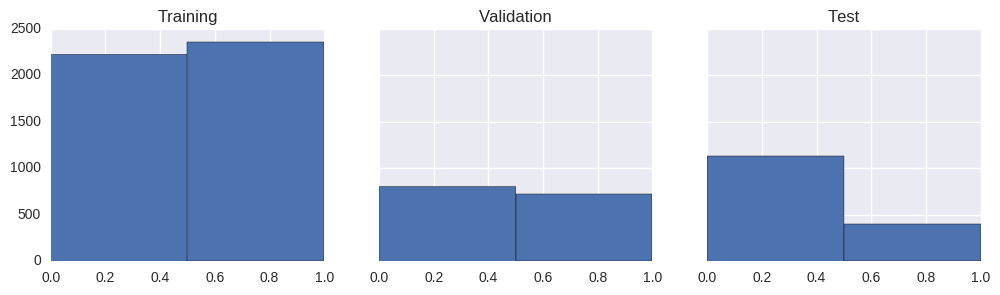

In [19]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,3))
axs[0].hist(df_tra.target, bins=2)
axs[1].hist(df_val.target, bins=2)
axs[2].hist(df_tst.target, bins=2)
axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[2].set_title('Test')

In [20]:
X_tra = df_tra.drop(labels=['target'], axis=1, inplace=False).values
y_tra = df_tra.target.values

X_val = df_val.drop(labels=['target'], axis=1, inplace=False).values
y_val = df_val.target.values

X_tst = df_tst.drop(labels=['target'], axis=1, inplace=False).values
y_tst = df_tst.target.values

# Normalization

For the sake of simplicity, we will use the **0-1 range** normalization:

$ x_i = \dfrac{x_i - min(x_i)}{max(x_i) - min(x_i)}$

This is allowed because we do not have that many 'outliers' in our features.

The **Alpha-Trimmed** normalization or **Standard Scaler** normalization would be more appropriate if we introduced other (interesting) features such as:
- Average cases/week in the neighborhood.
- Number of cases in the last X days in that neighborhood.



In [21]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler().fit(X_tra)
X_tra = normalizer.transform(X_tra)
X_val = normalizer.transform(X_val)
X_tst = normalizer.transform(X_tst)

# Feature Importance

## Variance Threshold

In [22]:
from sklearn.feature_selection import VarianceThreshold

print X_tra.shape
threshold=(.999 * (1 - .999))
sel = VarianceThreshold(threshold=threshold)
X_tra = sel.fit(X_tra).transform(X_tra)
X_val = sel.transform(X_val)
X_tst = sel.transform(X_tst)
print X_tra.shape

removed_features_1 = np.array(columns)[np.where(sel.variances_ < threshold)]
selected_features_1 = np.array(feature_columns)[np.where(sel.variances_ >= threshold)]

(4585, 60)
(4585, 56)


In [23]:
print 'removed_features'
print removed_features_1

removed_features
[u'cat__color_curb' u'cat__dpw_volunteer_programs' u'cat__muni_feedback'
 u'source__other_department']


## Correlation

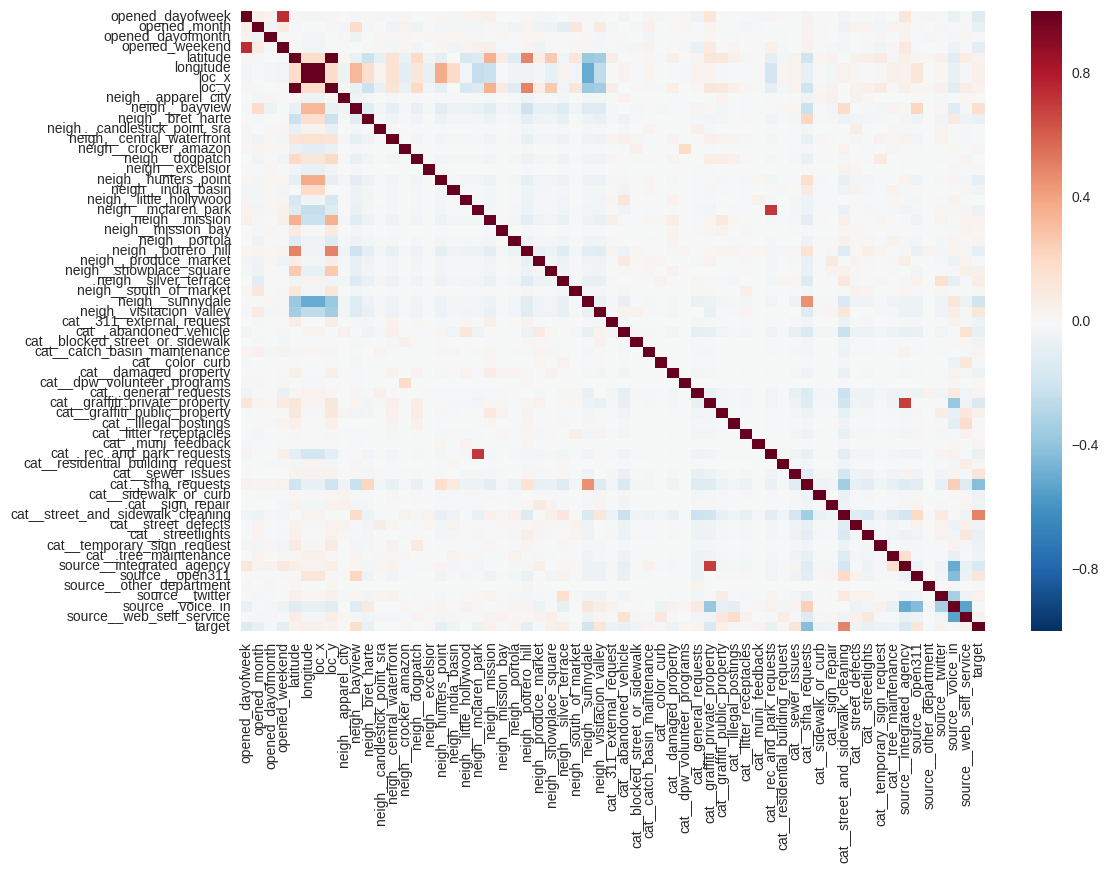

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr('pearson'))

features **loc_x** and **loc_y** are too correlated with **latitude** and **longitude**, respectively, for this reason, we'll delete **lox_x** and **loc_y**.

In [25]:
del df['loc_x']
del df['loc_y']

## Feature Importance (Trees)

This can be done using sklearn.feature_selection.SelectFromModel, however, we do it by ourselves in order to get a better visualization of the process.

In [26]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def feature_importance(X, y, feat_names, forest='random_forest', plot=False, print_=False):
    # Build a forest and compute the feature importances
    if forest == 'random_forest':
        forest = RandomForestClassifier(n_estimators=200, random_state=0)
    elif forest == 'extra_trees':
        forest = ExtraTreesClassifier(n_estimators=200, random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    sd = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    mn = np.mean([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking

    if print_:
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], feat_names[indices[f]]))

    if plot:
            
        plt.figure(figsize=(16,3))
        plt.title("Feature importances")
        plt.bar(range(len(importances)), importances[indices],
               color="r", yerr=sd[indices], align="center")
        plt.xticks(range(len(importances)), indices)
        plt.xlim([-1, len(indices)])
        plt.show()
        
    return indices, importances

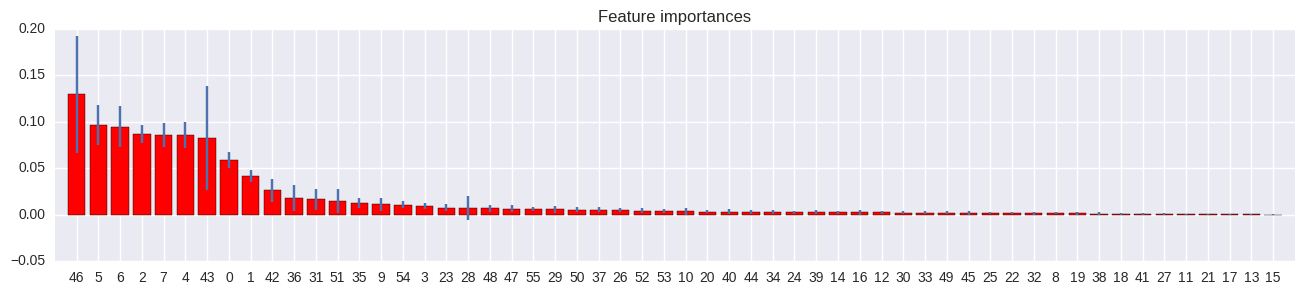

In [27]:
indices, importances = feature_importance(X_tra, y_tra, selected_features_1, plot=True, forest='random_forest')

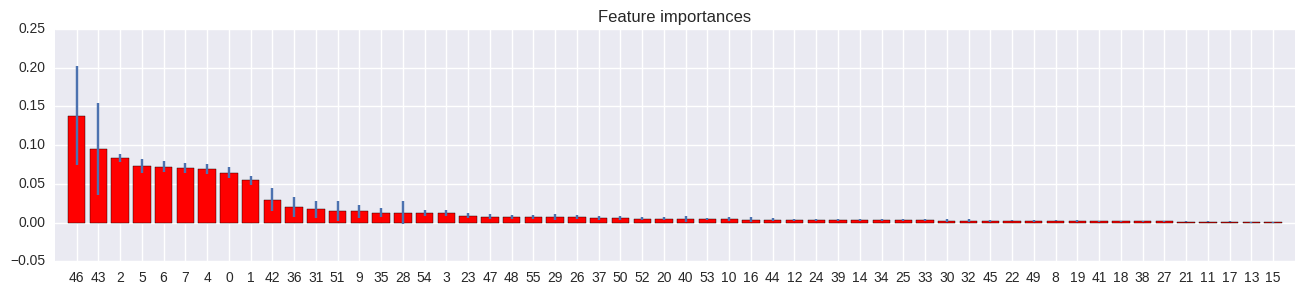

In [28]:
indices, importances = feature_importance(X_tra, y_tra, selected_features_1, plot=True, forest='extra_trees')

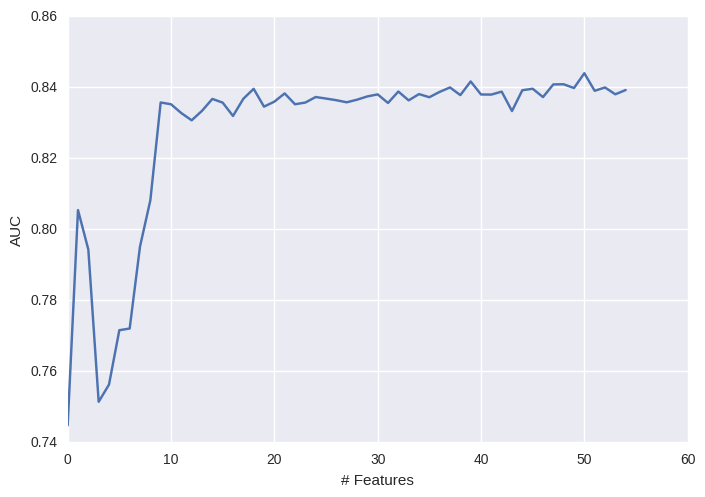

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
    
scores = []
for i in range(1,len(indices)):
    mask = indices[:i]
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_tra[:,mask], y_tra)
    score = roc_auc_score(y_val, clf.predict_proba(X_val[:,mask])[:,1])
    scores.append(score)
    
plt.plot(np.arange(len(scores)), scores)
plt.xlabel("# Features")
plt.ylabel("AUC")

In [30]:
max_index = np.argmax(scores)
sel_index = 18

Based on this results, we'll select the N features

In [31]:
selected_features_2 = np.array(selected_features_1)[indices[:sel_index]]

In [32]:
selected_features_2

array([u'cat__street_and_sidewalk_cleaning', u'cat__sfha_requests',
       u'opened_dayofmonth', u'longitude', u'loc_x', u'loc_y', u'latitude',
       u'opened_dayofweek', u'opened_month', u'cat__sewer_issues',
       u'cat__graffiti_private_property', u'cat__abandoned_vehicle',
       u'source__integrated_agency', u'neigh__bayview',
       u'cat__general_requests', u'neigh__sunnydale', u'source__voice_in',
       u'opened_weekend'], 
      dtype='<U33')

It seems like the **location** and **category** features are more important than the date related features.

On the date related features, the system also selected **opened_dayofweek** and **opened_dayofmonth**.

# Test Set

In [33]:
from sklearn.metrics import roc_curve, auc

def find_cutoff(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])[0]

In [35]:
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import Pipeline

def __feature_importance(X, y):
    forest = RandomForestClassifier(n_estimators=200, random_state=0)
    forest.fit(X, y)
    return forest.feature_importances_

pipe = Pipeline([
        ('normalizer', MinMaxScaler()),
        ('selection_threshold', VarianceThreshold(threshold=(.999 * (1 - .999)))),
        ('selection_kbest', SelectKBest(__feature_importance, k=31)),
        ('classifier', RandomForestClassifier(n_estimators=100))])

pipe.fit(X_tra, y_tra)
y_proba = pipe.predict_proba(X_tst)
cutoff = find_cutoff(y_tst, y_proba[:,1])

In [36]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresh = roc_curve(y_tst, y_proba[:,1])
auc_roc = auc(fpr, tpr)

cuttoff 0.5017


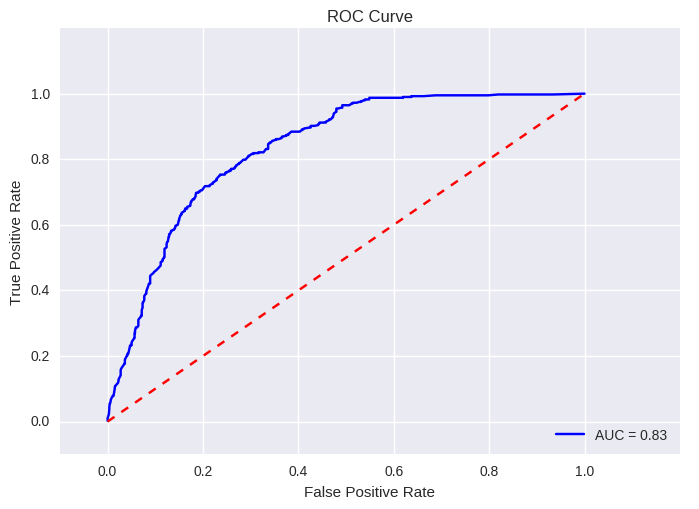

In [37]:
print 'cuttoff {:.4f}'.format(cutoff)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc_roc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
from sklearn.metrics import classification_report

In [39]:
print classification_report(y_tst, y_proba[:,1] >= cutoff)

             precision    recall  f1-score   support

      False       0.90      0.75      0.82      1132
       True       0.52      0.75      0.61       397

avg / total       0.80      0.75      0.77      1529



In [40]:
import sqlite3
from sqlalchemy import create_engine

SQL_ENGINE = create_engine('sqlite:///streetlight_cases.db')
df.to_sql('new_data', SQL_ENGINE, if_exists='replace', index=False)